# Analysis of vacant parcels in Charlottesville

In [1]:
import folium
import pandas as pd

from google.cloud import bigquery

/Users/josh.carp/miniconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
bq = bigquery.Client()

In [3]:
pd.set_option('display.max_rows', None)

## Select potentially vacant parcels

In [4]:
parcels = bq.query(
    """
        select
            details.geoparceli as gpin,
            details.parcelnumb as parcel_number,
            concat(coalesce(details.streetnumb, "?"), " ", details.streetname) as address,
            details.ownername as owner_name,
            details.zoning,
            flum.desig_oct as flum_designation,
            assessments.totalvalue as assessment,
            residential.usecode as use_code,
            frontage.length as frontage_length,
            dimensions.area as parcel_area,
            dimensions.bounding_rectangle_area as parcel_bounding_rectangle_area,
            dimensions.area_ratio as parcel_area_ratio,
            dimensions.dimensions as parcel_dimensions,
            st_geogfromgeojson(details.geometry) as geometry,
        from `cvilledata.cville_open_data.parcel_area_details` details
        left join `cvilledata.cville_plans_together.flum_202110` flum on details.parcelnumb = flum.parcelnumb
        left join `cvilledata.cville_open_data.real_estate_all_assessments` assessments on details.parcelnumb = assessments.parcelnumb and assessments.taxyear = 2022
        left join `cvilledata.cville_open_data.real_estate_residential_details` residential on details.parcelnumb = residential.parcelnumb
        join `cvilledata.cville_open_data_derived.road_frontage` frontage on details.geoparceli = frontage.gpin
        join `cvilledata.cville_open_data_derived.parcel_dimensions` dimensions on details.geoparceli = dimensions.gpin
        where
            (
                details.zoning like "R-%"
                or flum.desig_oct like "%Residential%"
                or flum.desig_oct like "%Neighborhood Mixed Use%"
                or flum.desig_oct like "%Urban Mixed Use%"
            ) -- Residential zoning
            and details.filetype != "E"  -- Exclude tax-exempt parcels
            and details.ownername not like "CONDO%"
            and details.ownername not like "HOMEOWNERS ASS%"
            and details.ownername not like "VIRGINIA ELECTRIC%"
            and details.parcelnumb not in ("560087100", "590371000") -- Exclude Sunshine Court, Mountain View mobile home parks
            and details.parcelnumb != "21A100000" -- Naylor St common area
            and assessments.improvemen < 30000  -- Limit to approximately vacant
            and residential.usecode not in ("Common Area", "Condo Common Area", "Condominium Commercial", "Parking Structure")
    """
).result().to_geodataframe()

## Map potentially vacant parcels

- Purple: Likely inadequate road frontage
- Orange: Likely inadequate lot dimensions

Note: road frontage and lot dimensions aren't provided by the city and are estimated from GIS data.

In [5]:
# Map vacant parcels

map_df = parcels[["gpin", "parcel_number", "address", "owner_name", "zoning", "flum_designation", "assessment", "use_code", "frontage_length", "parcel_dimensions", "geometry"]]
map_df.parcel_dimensions = map_df.parcel_dimensions.apply(list)  # Make list json-serializable
has_adequate_dimensions = parcels.parcel_dimensions.apply(lambda dimensions: dimensions[0] >= 40 and dimensions[1] >= 40)

map_ = folium.Map(
    location=[38.04, -78.49],
    tiles="cartodbpositron",
    zoom_start=13.5,
    zoom_delta=0.5,
)
tooltip = folium.GeoJsonTooltip(fields=["gpin", "parcel_number", "frontage_length"])
folium.GeoJson(
    map_df[(parcels.frontage_length > 10) & (has_adequate_dimensions)],
    style_function=lambda shape: {"fillColor": "green", "weight": 0.1, "fillOpacity": 0.5},
    tooltip=folium.GeoJsonTooltip(fields=["gpin", "parcel_number", "address", "owner_name", "zoning", "flum_designation", "assessment", "use_code", "frontage_length", "parcel_dimensions"]),
).add_to(map_)
folium.GeoJson(
    map_df[parcels.frontage_length <= 10],
    style_function=lambda shape: {"fillColor": "purple", "weight": 0.1, "fillOpacity": 0.5},
    tooltip=folium.GeoJsonTooltip(fields=["gpin", "parcel_number", "address", "owner_name", "zoning", "flum_designation", "assessment", "use_code", "frontage_length", "parcel_dimensions"]),
).add_to(map_)
folium.GeoJson(
    map_df[~has_adequate_dimensions],
    style_function=lambda shape: {"fillColor": "orange", "weight": 0.1, "fillOpacity": 0.5},
    tooltip=folium.GeoJsonTooltip(fields=["gpin", "parcel_number", "address", "owner_name", "zoning", "flum_designation", "assessment", "use_code", "frontage_length", "parcel_dimensions"]),
).add_to(map_)
map_

/Users/josh.carp/miniconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [6]:
## Plot distributions of road frontage and parcel dimensions

<AxesSubplot:title={'center':'Distribution of road frontage length, feet'}, ylabel='Frequency'>

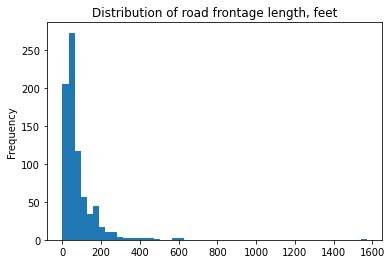

In [7]:
parcels.frontage_length.plot.hist(bins=50, title="Distribution of road frontage length, feet")

<AxesSubplot:title={'center':'Distribution of parcel area, square feet'}, ylabel='Frequency'>

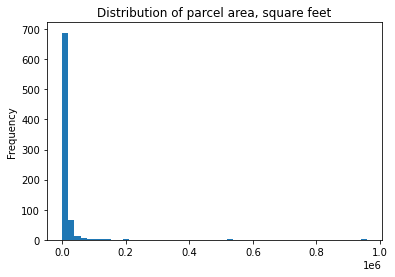

In [8]:
parcels.parcel_area.plot.hist(bins=50, title="Distribution of parcel area, square feet")

<AxesSubplot:title={'center':'Distribution of short parcel dimension, feet'}, ylabel='Frequency'>

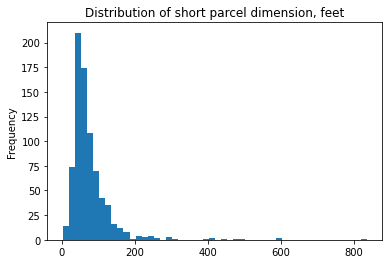

In [9]:
parcels.parcel_dimensions.apply(lambda dimensions: dimensions[0]).plot.hist(bins=50, title="Distribution of short parcel dimension, feet")

In [10]:
parcels.drop(columns=["geometry"]).to_csv("vacancies.csv")

In [11]:
parcels

,gpin,parcel_number,address,owner_name,zoning,flum_designation,assessment,use_code,frontage_length,parcel_area,parcel_bounding_rectangle_area,parcel_area_ratio,parcel_dimensions,geometry
0,1492,010005000,0 BARRACKS RD,"BOOKER, ELIZABETH A M TRUSTEE",R-1U,Medium-Intensity Residential,317900,Vacant Land,100.724086,34718.909075,3.753906e+04,0.924874,"[102.73, 365.43]","POLYGON ((-78.49808 38.05159, -78.49894 38.051..."
1,2350,020071000,0 RUGBY RD,"DULANEY, JAMES, JR & RETA D HURD",R-1U,Medium-Intensity Residential,346700,Vacant Land,96.687924,21998.736125,2.344603e+04,0.938271,"[96.82, 242.16]","POLYGON ((-78.49535 38.04544, -78.49502 38.044..."
2,2487,030057000,0 PRESTON AVE,HARDWARE RIVER COMPANY LLC,R-1,High-Intensity Residential,40400,Vacant Land,0.000000,9967.764351,1.070618e+04,0.931029,"[59.92, 178.67]","POLYGON ((-78.49221 38.04476, -78.49222 38.044..."
3,2730,030139100,0 CABELL AVE,SORENSEN PAMELA H,R-2U,Medium-Intensity Residential,747700,Vacant Land,198.688520,37811.132361,3.842198e+04,0.984101,"[160.74, 239.03]","POLYGON ((-78.49449 38.04403, -78.49435 38.043..."
4,4414,040069000,0 10 1/2 ST NW,OP TWO LLC,R-1S,General Residential,50200,Vacant Land,54.723506,3269.875738,3.310995e+03,0.987581,"[55.54, 59.62]","POLYGON ((-78.49307 38.03850, -78.49288 38.038..."
5,5281,040266000,1103 PAGE ST,"JONES, BETTY",R-1SU,General Residential,68800,Vacant Land,26.245360,3327.105345,3.496516e+03,0.951549,"[26.59, 131.51]","POLYGON ((-78.49501 38.03629, -78.49509 38.036..."
6,5659,040298000,208 14TH ST NW,"DABNEY, KIM TRAN",B-1H,High-Intensity Residential,564900,Parking Lot,49.958796,6768.366100,6.959990e+03,0.972468,"[49.67, 140.11]","POLYGON ((-78.49899 38.03503, -78.49853 38.034..."
7,3561,050047100,0 RUGBY RD,"WEST RANGE CASTLE DANGO, LLC",R-3H,High-Intensity Residential,235000,Vacant Land,96.632799,14285.353644,1.508157e+04,0.947206,"[96.82, 155.77]","POLYGON ((-78.50126 38.04144, -78.50128 38.041..."
8,3576,080013000,0 IVY RD & CAMERON LN,"ECKERT, ALEXANDRA C & HAMLIN, AUSTIN C",R-1U,Urban Mixed Use Corridor,200400,Vacant Land,259.227635,13592.992046,1.533599e+04,0.886346,"[91.71, 167.22]","POLYGON ((-78.50962 38.04139, -78.50979 38.041..."
9,4773,090133000,0 CHANCELLOR ST,"ETA, ALUMNI INC",R-3H,Medium-Intensity Residential,235700,Vacant Land,52.847588,5788.263932,6.060031e+03,0.955154,"[54.51, 111.17]","POLYGON ((-78.50118 38.03759, -78.50083 38.037..."
